# 作业1:无穷嵌套的根式

2025-9-03

## 数值探索

### 计算前准备

导入需要的库，并针对 Jupyter Notebook 进行一些设置.

In [6]:
import numpy as np # 数值计算库
import numba as nb # 引入 jit 来加速函数
import sympy as sym # 符号计算库
import matplotlib.pyplot as plt # 图像绘制
import ipywidgets as ipw # 交互控件

# 使用 mathjax 来在 jupyter notebook 显示数学公式
sym.init_printing(use_latex='mathjax')

# 设置 matplotlib 绘制的图像嵌入到 jupyter notebook
%matplotlib widget

# 设置 matplotlib 使用的字体，避免出现中文问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### 问题（1）

这里我们先根据题目，定义一个函数，其传入一个值（数组），以及需要迭代的次数，返回指定迭代次数的根式嵌套的值.

In [35]:
def fn(x, n=20, y0=1):
    y = np.ones_like(x) * y0
    for i in range(n):
        y = np.sqrt(x+y)
    return y

传入课件中的第一小问的值 $x=42$，验证 $y\to7$

In [36]:
fn(42)

np.float64(7.0)

这符合题目的预期值 $7$，也说明上述函数是符合要求的. 当然，我们也可以绘制出迭代收敛的过程：

Text(0.5, 1.0, '迭代次数和函数值的关系')

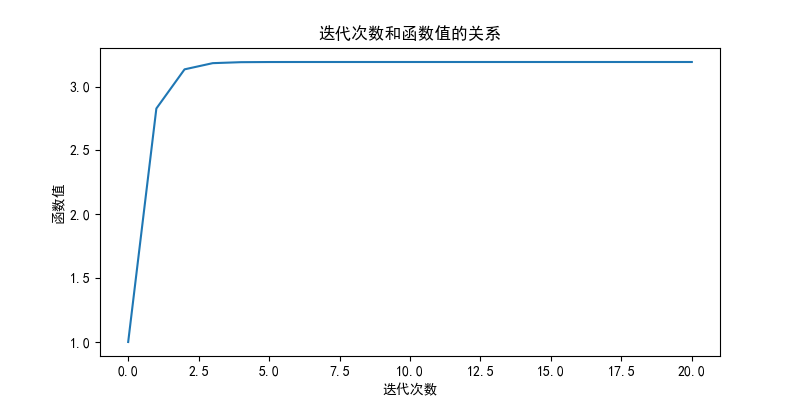

In [39]:
def fn_track(x, n=20, y0=1):
    n_arr = np.arange(n+1)
    y_arr = np.zeros((n+1, len(x)))
    y_arr[0] = y0 * np.ones_like(x)
    for i in range(n):
        y_arr[i+1] = np.sqrt(x + y_arr[i])
    return n_arr, y_arr

n_arr, y_arr = fn_track(np.array([7]))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(n_arr, y_arr)
ax.set_xlabel("迭代次数")
ax.set_ylabel("函数值")
ax.set_title("迭代次数和函数值的关系")

### 问题（2）

现在我们来探究当 $x$ 取其他的值时的收敛情况，上述函数的实现过程中实际上是向量化的，因此我们只需传入数组即可.

Text(0.5, 1.0, '迭代次数和函数值的关系')

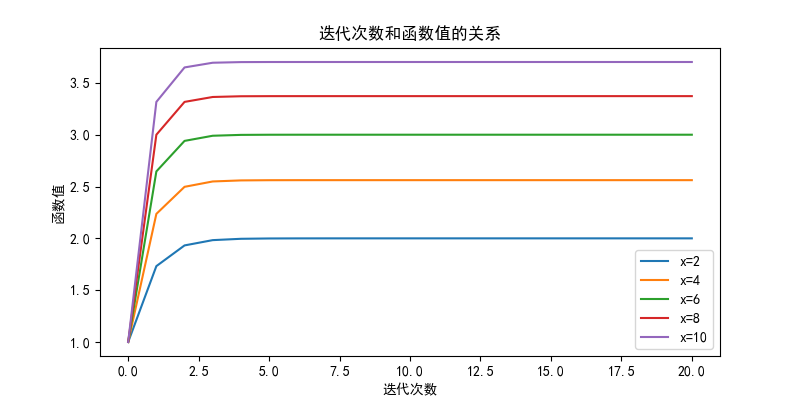

In [47]:
x_arr = np.arange(2,11,2) # 计算输入为 2,4,6,8,10 的情况
n_arr, y_arr = fn_track(x_arr)
fig, ax = plt.subplots(figsize=(8,4))
for i, x in enumerate(x_arr):
    ax.plot(n_arr, y_arr[:,i], label=f"x={x}")
ax.set_xlabel("迭代次数")
ax.set_ylabel("函数值")
ax.legend()
ax.set_title("迭代次数和函数值的关系")

我们也可以使用交互控件动态地进行绘制.

interactive(children=(FloatSlider(value=10.0, description='x', max=20.0), Output()), _dom_classes=('widget-int…

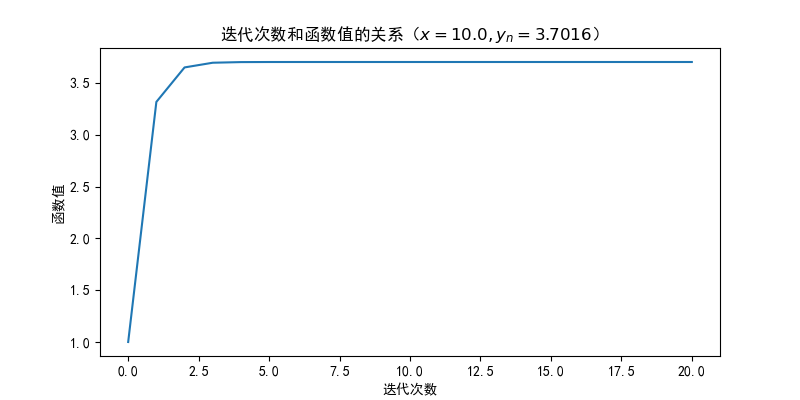

In [54]:
fig, ax = plt.subplots(figsize=(8, 4))

@ipw.interact(x=(0,20,0.1))
def update_plot(x):
    ax.clear() # 清除画布
    n_arr, y_arr = fn_track(np.array([x]))
    ax.plot(n_arr, y_arr, label=f"x={x}")
    ax.set_xlabel("迭代次数")
    ax.set_ylabel("函数值")
    ax.set_title(f"迭代次数和函数值的关系（$x={x}, y_n={y_arr[-1][0]: .4f}$）")

当然，在以上的所有的函数中，我们都人为给定了迭代次数 $n$，并通过绘制图像来说明当 $n$ 足够大时收敛. 这并不符合我们之后的讨论（固定 $n$ 无法说明已经收敛，也不可能每给定一个 $n$ 都绘图验证收敛）. 因此我们可以通过计算

In [3]:
@nb.njit()
def ft(x, n=100):
    ans = np.zeros((n+1, len(x)))
    xt = np.arange(n+1)
    ans[0] = x.copy()
    for i in range(n):
        ans[i+1] = np.sqrt(ans[i])
    return xt, ans

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
def callback(x):
    ax.clear()
    xt, yt = ft(np.array([x]))
    ax.plot(xt, yt)
ipw.interact(callback, x=(0, 2, 0.01))

测试代码框（导出前应该删除）